In [1]:
# Program to rename all image file


# import os
# os.chdir(r'C:\Users\Admin\OneDrive\Desktop\Lung Data\tuberculosis')
# print(os.getcwd())

# #Display number with leading zeros

# for count, f in enumerate(os.listdir()):
# 	f_name, f_ext = os.path.splitext(f)
# 	f_name = "tuberculosis" + str(count).zfill(5)

# 	new_name = f'{f_name}{f_ext}'
# 	os.rename(f, new_name)

In [2]:
#Program for resize the images

# import PIL
# import os
# import os.path
# from PIL import Image

# f = r'C:\Users\Admin\OneDrive\Desktop\Lung Data\tuberculosis'

# for file in os.listdir(f):
#     f_img = f+"/"+file
#     img = Image.open(f_img)
#     img = img.resize((224,2 24))
#     img.save(f_img)

In [3]:
#Clahe for image enhancement

# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# import glob
# import time

# input = r'C:\Users\Admin\OneDrive\Desktop\Lung Data\covid'
# i = 0
# #start = time.time()
# for img in glob.glob(input + '/*.jpg'):
#     #Test%04i.png
#     image = cv2.imread(r'C:\Users\Admin\OneDrive\Desktop\Lung Data\covid\covid%05i.jpg'%i,0)
#     #Creating CLAHE 
#     clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(10,10))
#     #Apply CLAHE to the original image
#     image_clahe = clahe.apply(image)
#     cv2.imwrite(r'C:\Users\Admin\OneDrive\Desktop\Lung Data\covid\covid%05i.jpg'%i,image_clahe)
#     i += 1


In [4]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 100)
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf 

import os

/Users/apple-b/Desktop/work/python_env/deeplearning/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
path_code = os.getcwd()
image_dir = Path(f'{path_code}/data_lung/')
filepaths = list(image_dir.glob(r'**/**/*.jpg')) + list(image_dir.glob(r"**/**/*.png"))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

In [6]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(10)

,Filepath,Label
0,/Users/apple-b/Desktop/ubco_mds/data586/project/data_lung/train/effusion/effusion00125.jpg,effusion
1,/Users/apple-b/Desktop/ubco_mds/data586/project/data_lung/train/covid/covid00451.jpg,covid
2,/Users/apple-b/Desktop/ubco_mds/data586/project/data_lung/train/pneumonia/pneumonia00484.jpg,pneumonia
3,/Users/apple-b/Desktop/ubco_mds/data586/project/data_lung/test/pulmunary fibrosis/pulmunary fibr...,pulmunary fibrosis
4,/Users/apple-b/Desktop/ubco_mds/data586/project/data_lung/train/pulmunary fibrosis/pulmunary fib...,pulmunary fibrosis
5,/Users/apple-b/Desktop/ubco_mds/data586/project/data_lung/train/nodule/nodule00148.jpg,nodule
6,/Users/apple-b/Desktop/ubco_mds/data586/project/data_lung/train/control/control00145.jpg,control
7,/Users/apple-b/Desktop/ubco_mds/data586/project/data_lung/train/pneumothorax/pneumothorax00477.jpg,pneumothorax
8,/Users/apple-b/Desktop/ubco_mds/data586/project/data_lung/train/effusion/effusion00179.jpg,effusion
9,/Users/apple-b/Desktop/ubco_mds/data586/project/data_lung/train/nodule/nodule00432.jpg,nodule


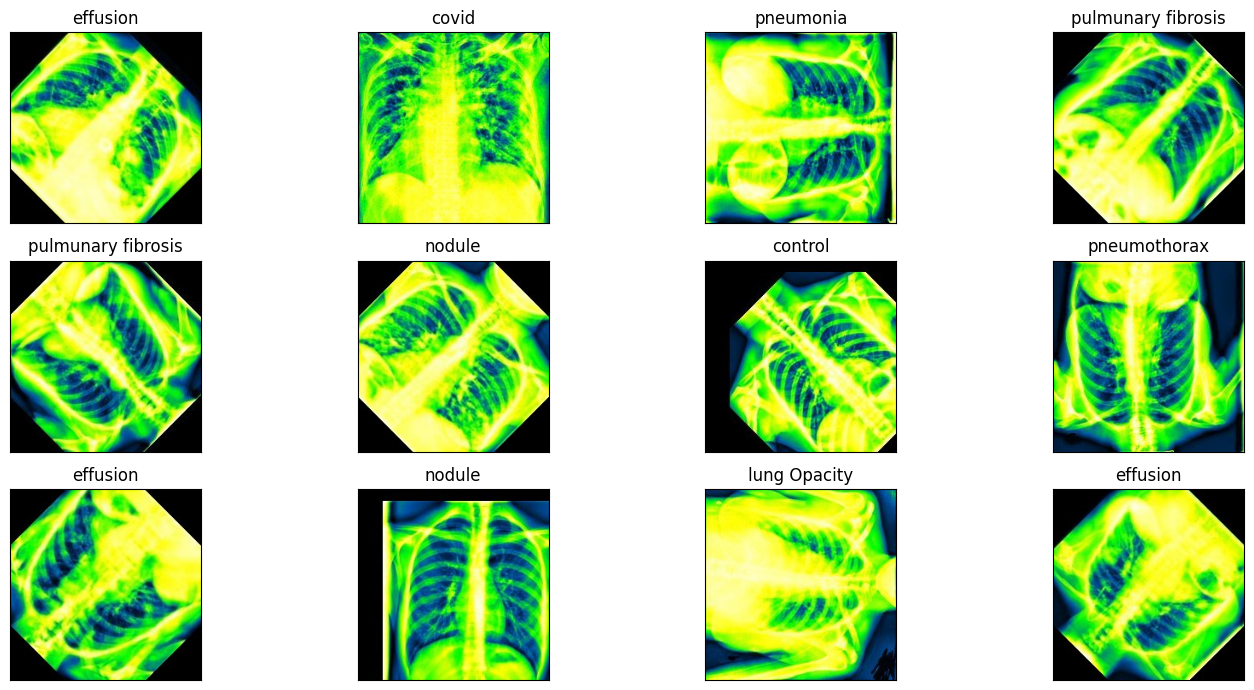

In [7]:
# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [8]:
# Separate in train and test data
image_df['dataset'] = image_df['Filepath'].apply(lambda x: x.split('/')[-3])

train_df = image_df[image_df['dataset']=='train']
test_df = image_df[image_df['dataset']=='test']
print(train_df.shape, test_df.shape, image_df.shape)


(4054, 3) (1019, 3) (5073, 3)


In [9]:
# Configure GPU usage (Mac M2 specific)
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Ignore errors if no GPU is found
  pass

print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3244 validated image filenames belonging to 10 classes.
Found 810 validated image filenames belonging to 10 classes.
Found 1019 validated image filenames belonging to 10 classes.


In [12]:
# # Load the pretained model
# pretrained_model = tf.keras.applications.VGG19(
#     input_shape=(224, 224, 3),
#     include_top=False,
#     weights='imagenet',
#     pooling='avg'
# )

# Load VGG19 excluding the last layer
pretrained_model = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,  # This removes the last layer
    weights='imagenet'
)

pretrained_model.trainable = False
pretrained_model.summary()

2024-04-16 20:46:38.405183: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-04-16 20:46:38.405208: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-04-16 20:46:38.405215: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-04-16 20:46:38.405237: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-16 20:46:38.405250: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [13]:
# Access the output of the pre-trained model (already without the last layer)
output = pretrained_model.output

# Apply the new Conv2d block to the output
x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block6_conv1')(output)
x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block6_conv2')(x)
x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block6_conv3')(x)
x = tf.keras.layers.GlobalAveragePooling2D(name='block6_gap')(x)
x = tf.keras.layers.Flatten(name='block7_flatten')(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)

# Create a new model with the combined layers
model = tf.keras.Model(inputs=pretrained_model.input, outputs=x, name='LungNet22')
model.summary()

Model: "LungNet22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block6_conv1 (Conv2D)           │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block6_conv2 (Conv2D)           │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block6_conv3 (Conv2D)           │ (None, 7, 7, 512)      │     2,359,80

 Total params: 27,108,938 (103.41 MB)

 Trainable params: 7,084,554 (27.03 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [14]:
# #Model LungNet22

# from tensorflow.python.keras.layers.pooling import MaxPool2D
# from tensorflow.python.keras.layers.core import Activation
# # from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
# from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D

# inputs = pretrained_model.input

# x = tf.keras.layers.Flatten()(pretrained_model.output)
# #x = tf.keras.layers.Dense(128, activation='relu')(x)

# outputs = tf.keras.layers.Dense(10, activation='softmax')(x)


# model = tf.keras.Model(inputs=inputs, outputs=outputs, name="LungNet22")
# model.summary()


model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [15]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=300,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

# history = model.fit(
#           train_images,
#           epochs = 5,
#           verbose=1,
#           validation_data = val_images,
#           )

Epoch 1/300


2024-04-16 20:46:39.462181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/apple-b/Desktop/work/python_env/deeplearning/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 376ms/step - accuracy: 0.1393 - loss: 10.5463 - val_accuracy: 0.2160 - val_loss: 1.9890
Epoch 2/300
102/102 ━━━━━━━━━━━━━━━━━━━━ 39s 378ms/step - accuracy: 0.2614 - loss: 1.9206 - val_accuracy: 0.3123 - val_loss: 1.7886
Epoch 3/300
102/102 ━━━━━━━━━━━━━━━━━━━━ 39s 382ms/step - accuracy: 0.3357 - loss: 1.7282 - val_accuracy: 0.4148 - val_loss: 1.5310
Epoch 4/300
102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 386ms/step - accuracy: 0.4174 - loss: 1.5033 - val_accuracy: 0.4543 - val_loss: 1.4006
Epoch 5/300
102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 386ms/step - accuracy: 0.5101 - loss: 1.2886 - val_accuracy: 0.5049 - val_loss: 1.3529
Epoch 6/300
102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 389ms/step - accuracy: 0.5553 - loss: 1.1394 - val_accuracy: 0.5370 - val_loss: 1.1991
Epoch 7/300
102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 392ms/step - accuracy: 0.6259 - loss: 0.9496 - val_accuracy: 0.5642 - val_loss: 1.1799
Epoch 8/300
102/102 ━━━━━━━━━━━━━━━━━━━━ 39s 384ms/step - accuracy: 0.6797 - loss: 0.86

In [16]:
# Save the model to a file
model.save('LungNet22_vgg19mini.h5')

# Load the saved model
model = tf.keras.models.load_model('LungNet22_vgg19mini.h5')

# Use the loaded model for predictions or further training
# loaded_model.predict(new_data)

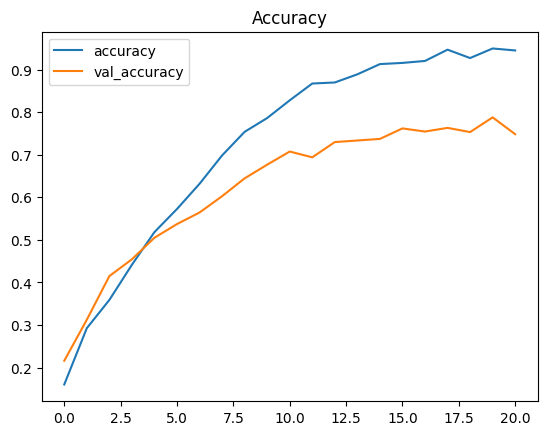

In [17]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()
#model.summary()

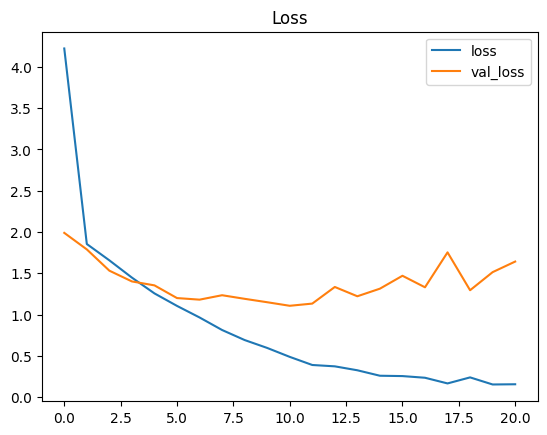

In [18]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [19]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

/Users/apple-b/Desktop/work/python_env/deeplearning/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


    Test Loss: 1.06260
Test Accuracy: 70.66%


In [20]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 6 predictions: {pred[:6]}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 284ms/step
The first 6 predictions: ['pneumonia', 'effusion', 'tuberculosis', 'pneumothorax', 'effusion', 'nodule']


In [21]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                    precision    recall  f1-score   support

           control       0.96      1.00      0.98       116
             covid       0.94      0.96      0.95       101
          effusion       0.57      0.60      0.58       100
      lung Opacity       0.69      0.61      0.65       100
              mass       0.64      0.58      0.61       101
            nodule       0.78      0.72      0.75       101
         pneumonia       0.52      0.47      0.49       100
      pneumothorax       0.74      0.64      0.69       100
pulmunary fibrosis       0.53      0.81      0.64        99
      tuberculosis       0.73      0.62      0.67       101

          accuracy                           0.71      1019
         macro avg       0.71      0.70      0.70      1019
      weighted avg       0.71      0.71      0.71      1019



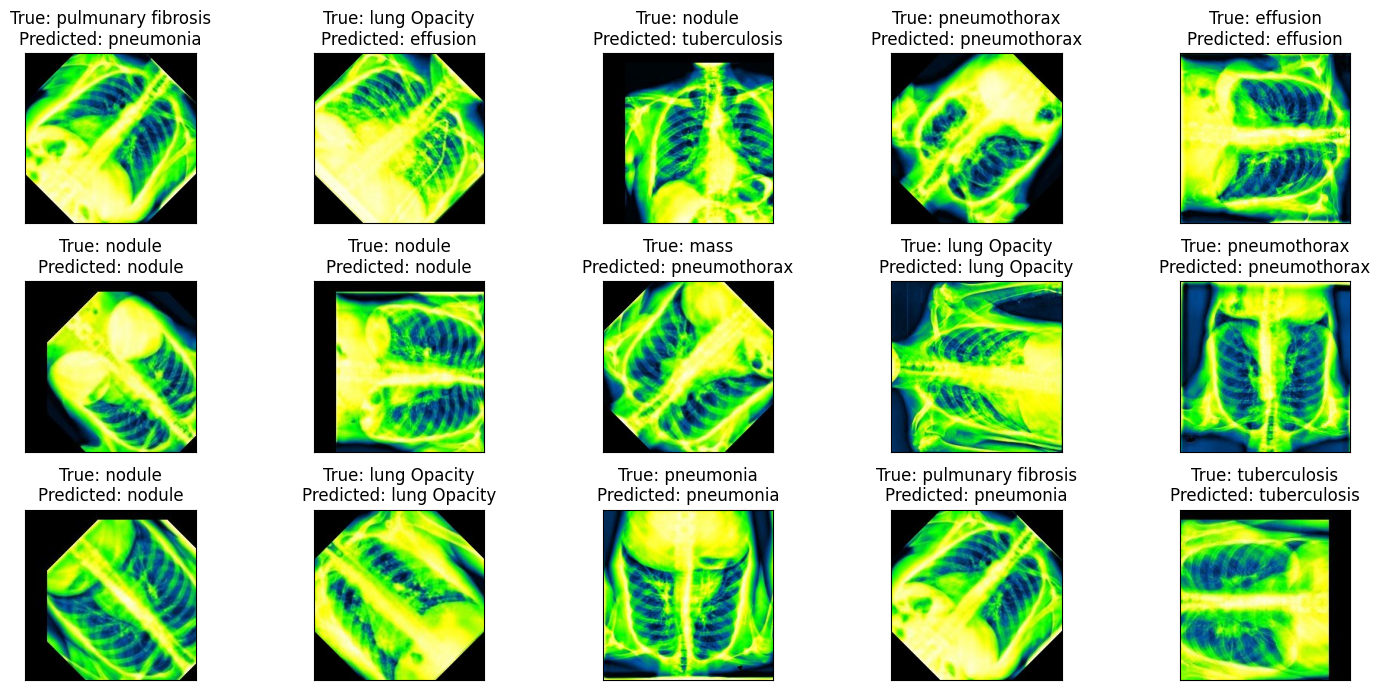

In [22]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [48]:
# def get_img_array(img_path, size):
#     img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
#     array = tf.keras.preprocessing.image.img_to_array(img)
#     # We add a dimension to transform our array into a "batch"
#     # of size "size"
#     array = np.expand_dims(array, axis=0)
#     return array

# def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
#     # First, we create a model that maps the input image to the activations
#     # of the last conv layer as well as the output predictions
#     # grad_model = tf.keras.models.Model(
#     #     [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
#     # )
#     grad_model = tf.keras.models.Model(
#         model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
#     )

#     # Then, we compute the gradient of the top predicted class for our input image
#     # with respect to the activations of the last conv layer
#     with tf.GradientTape() as tape:
#         last_conv_layer_output, preds = grad_model(img_array)
#         if pred_index is None:
#             pred_index = tf.argmax(preds[0])
#         class_channel = preds[:, pred_index]
    
#     # This is the gradient of the output neuron (top predicted or chosen)
#     # with regard to the output feature map of the last conv layer
#     grads = tape.gradient(class_channel, last_conv_layer_output)

#     # This is a vector where each entry is the mean intensity of the gradient
#     # over a specific feature map channel
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

#     # We multiply each channel in the feature map array
#     # by "how important this channel is" with regard to the top predicted class
#     # then sum all the channels to obtain the heatmap class activation
#     last_conv_layer_output = last_conv_layer_output[0]
#     heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
#     heatmap = tf.squeeze(heatmap)

#     # For visualization purpose, we will also normalize the heatmap between 0 & 1
#     heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
#     return heatmap.numpy()

# def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
#     # Load the original image
#     img = tf.keras.preprocessing.image.load_img(img_path)
#     img = tf.keras.preprocessing.image.img_to_array(img)

#     # Rescale heatmap to a range 0-255
#     heatmap = np.uint8(255 * heatmap)

#     # Use jet colormap to colorize heatmap
#     jet = cm.get_cmap("jet")

#     # Use RGB values of the colormap
#     jet_colors = jet(np.arange(256))[:, :3]
#     jet_heatmap = jet_colors[heatmap]

#     # Create an image with RGB colorized heatmap
#     jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
#     jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
#     jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

#     # Superimpose the heatmap on original image
#     superimposed_img = jet_heatmap * alpha + img
#     superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

#     # Save the superimposed image
#     superimposed_img.save(cam_path)

#     # Display Grad CAM
# #     display(Image(cam_path))
    
#     return cam_path
    
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

# last_conv_layer_name = "block5_conv4"
# img_size = (224,224)

# # Remove last layer's softmax
# model.layers[-1].activation = None

In [142]:
# # Display the part of the pictures used by the neural network to classify the pictures
# fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
#                         subplot_kw={'xticks': [], 'yticks': []})

# for i, ax in enumerate(axes.flat):
#     img_path = test_df.Filepath.iloc[i]
#     img_array = preprocess_input(get_img_array(img_path, size=img_size))
#     heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
#     cam_path = save_and_display_gradcam(img_path, heatmap)
#     ax.imshow(plt.imread(cam_path))
#     ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
# plt.tight_layout()
# plt.show()